<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/PyCon_de_2019_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playgroung based on [this talk](de.pycon.org/program/pydata-mmxquc-creating-an-interactive-ml-conference-showcase-harald-bosch/)

Github: https://github.com/boschhd/2019-PyConDE-PyData

In [1]:
# Necessary Imports
%matplotlib inline

# always needed
import numpy as np
np.set_printoptions(edgeitems=2)

# image related
# from ipywebrtc import CameraStream, ImageRecorder   -- doesn't work here
import io
import PIL.Image

# output related
import matplotlib.pyplot as plt
from ipywidgets import widgets, Label, HTML

# ML related
from keras import applications
from sklearn import svm, neighbors

Using TensorFlow backend.


# Set Up

We make use of [ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/) to send images securely from the browser to the python kernel. In theory, this means that even Android/iOS devices can directly capture images and send them to this notebook. 

The CameraStream is only MediaStream in the Browser and not sent to the server, only single images from the ImageRecorder are transmitted.


# UPD

ipywebrtc doesn't work in colab, using some JS-based script from https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=buJCl90WhNfq

In [0]:
# https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=SucxddsPhOmj

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


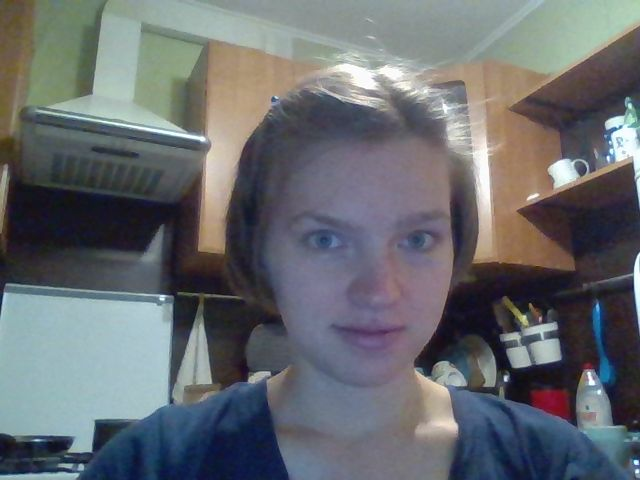

In [3]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7FA8FC4C95C0>


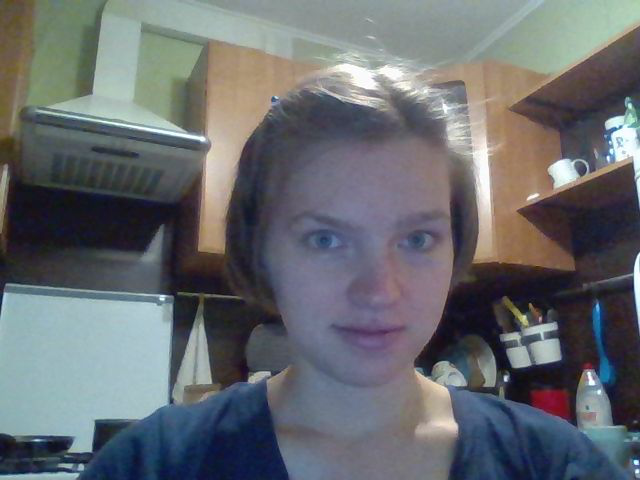

(480, 640, 3)
[[[ 79  74  68]
  [ 80  76  65]
  ...
  [172 206 171]
  [173 207 172]]

 [[ 82  78  69]
  [ 83  79  68]
  ...
  [172 206 171]
  [173 207 172]]

 ...

 [[142 174 173]
  [143 175 174]
  ...
  [ 74  89 112]
  [ 81  95 121]]

 [[142 173 168]
  [142 173 168]
  ...
  [ 66  80 106]
  [ 65  79 105]]]


In [4]:
# import io 
# import PIL.Image 


img = PIL.Image.open(filename)
 
print(img) 
display(img) 
 
img_array = np.asarray(img, dtype='int') 
print(img_array.shape) 
print(img_array)

### Feature Extraction 
 
We harness the work that has already been invested into training an image classifier. We take a pretrained neural network provided by [Keras](https://keras.io/applications/#mobilenet) and slice out an intermediate data structure (`include_top=False`) which was very helpfull to classify images into 1000 categories ([Imagenet dataset](http://image-net.org/challenges/LSVRC/2014/browse-synsets)). It should give us a good foundation for our simple task. 
 
This function creates a dense vector which "describes" the image content better than the raw pixel data.

In [5]:
#from keras import applications 
 
# download the model that was pretrained on many images and many classes 
cnn = applications.mobilenet.MobileNet( 
 include_top=False, 
 weights='imagenet', 
 input_shape=(480, 640, 3), 
 pooling = 'avg') 
 
# convert the pixel data into a semantically rich feature vector 
def extract_features(img): 
  img_array = np.asarray(img, dtype='int') 
  img_wo_alpha = img_array[:,:,:3] # remove the alpha channel (4th channel in 3rd dimension) 
  img_wo_alpha = applications.mobilenet.preprocess_input(img_wo_alpha) # scale to range [-1;1] 
  return cnn.predict(np.array([img_wo_alpha])) # wrap into additiobal array: (480,640,3) -> (1,480,640,3) 
 
# test function: 
print(extract_features(img)) 
print("extracted", extract_features(img).shape, "features from", img_array.size, "values")

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


[[0.67259324 0.06885032 ... 0.5296851  1.3283676 ]]
extracted (1, 1024) features from 921600 values


# Training 
 
We will use the above functions to capture some trainings images, extract the features and train a very simple classifier "


In [6]:
# reset our training data to empty arrays of the correct size 
X = np.ndarray((0,1024)) 
Y = np.ndarray((0,)) 
 
print(X.shape) 
print(Y.shape)

(0, 1024)
(0,)


### Collect Images 
 
As a widget, `ImageRecorder`'s properties are observable [Traitlets](https://traitlets.readthedocs.io/en/stable/using_traitlets.html#observe), this allows to register a callback on each value change, which processes the image and stores the features (input) and lables (desired output) into the global variables for the training data.

In [9]:
#from ipywidgets import Label, widgets 
 
label = input("Current Capture Label: ") 
 
outputLabel = Label(value = "") 


def collect_observation(): 
  filename = take_photo()
  img = PIL.Image.open(filename)
  
  x = extract_features(img) 
  y = label 
  
  global X 
  global Y 
  
  X = np.append(X, x, axis=0) 
  Y = np.append(Y, y) 
  
  classes, counts = np.unique(Y, return_counts=True) 
  outputLabel.value = str([": ".join((str(a),str(b))) for a,b in zip(classes, counts)])
  
  return img


for i in range(10):
  img = collect_observation()
  # display(img, outputLabel)

Current Capture Label: down


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Train Classifier 
 
Because the feature extractor is doing most of the work, the actual classificator is very simple and quick to update

down


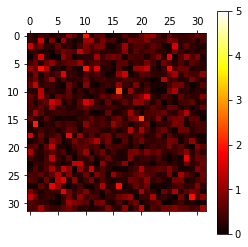

up


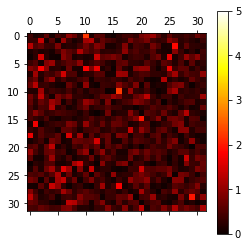

In [10]:
#from sklearn import svm, neighbors 
#import matplotlib.pyplot as plt 
#%matplotlib inline 
 
# you can try these two classification models by uncommenting them 
classification_model = neighbors.KNeighborsClassifier(n_neighbors=6) 
# classification_model= svm.SVC(gamma='scale', decision_function_shape='ovo', probability=True) 
 
classification_model.fit(X, Y) 
 
# additionally we can calculate an average of all veature vectors for each class just for the fun of it. 
for clazz in np.unique(Y): 
    print(clazz) 
    plt.matshow(np.reshape(np.average(X[Y == clazz],axis=0), (32,32)), cmap='hot', vmin=0, vmax=5) 
    plt.colorbar() 
    plt.show()

# Use 
Here, we define a function that uses the trained classifier on a new image by *repeating the same preprocessing steps* and predicting the best fitting label. It returns not only the label, but also the probability and the extracted feature vector.

In [11]:
def classify(image): 
    feature_vector = extract_features(image) 
    prediction = classification_model.predict(feature_vector) 
    prediction_proba = np.max(classification_model.predict_proba(feature_vector)) 
    return prediction[0], prediction_proba, feature_vector 

classify(img)

('down',
 0.8333333333333334,
 array([[0.1685084 , 0.09118579, ..., 0.4219615 , 1.3425244 ]],
       dtype=float32))

## Bring everything together 
In the following, we combine all of the above to classify the camera image in real-time. Using a callback on the webcam's value change events, we classify one image and after we are done we ask for the next one. After clicking on the camera icon you will see the recorded image and the result as a text below the images. 
 
You can stop the process with the stop sign button. After that you have to execute the cell again to repeat the process.

In [15]:
from ipywidgets import widgets, HTML 
 
# in- and output 
resultLabel = widgets.HTML() 
button = widgets.Button(description='Stop', icon="stop-circle") 
 
# abort button 
proceed = True 
def stop_callback(event): 
    global proceed 
    proceed = False 

button.on_click(stop_callback) 
 
# computation 
def inference_callback(): 
    filename = take_photo()
    img = PIL.Image.open(filename)
    
    result, conf, feature_vector = classify(img) 
    resultLabel.value = "<h2>I see <strong>&quot;{}&quot;</strong> and I'm <strong>{:0.2f}%</strong> certain about it</h2>".format(result, conf*100) 
    print(resultLabel.value)


# combine it into one cell 
#widgets.VBox([button, resultLabel])

for _ in range(10):
  inference_callback()

<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;up&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;up&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;down&quot;</strong> and I'm <strong>83.33%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;down&quot;</strong> and I'm <strong>83.33%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;down&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;down&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;down&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;up&quot;</strong> and I'm <strong>83.33%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;up&quot;</strong> and I'm <strong>66.67%</strong> certain about it</h2>


<IPython.core.display.Javascript object>

<h2>I see <strong>&quot;up&quot;</strong> and I'm <strong>100.00%</strong> certain about it</h2>
